# <center> **Práctica de Series Temporales** <center>

En el presente proyecto, se va a abordar un análisis de series temporales univariante que tiene como objetivo:


*   Determinar si es una serie es estacionaria o no, utilizando diferentes procedimientos. En este punto es necesario realizar análisis gráficos y diferentes test.

*   Determinar si es una serie es estacional y en su caso cual es la frecuencia con la que se da la estacionalidad.

*   Determinar cuál es modelo óptimo para estimar. Para ello se puede utilizar el autoarima u otro tipo de análisis.

*  Comprobar que el modelo estimado es correcto. Para este punto es necesario tanto analizar las predicciones como los residuos.

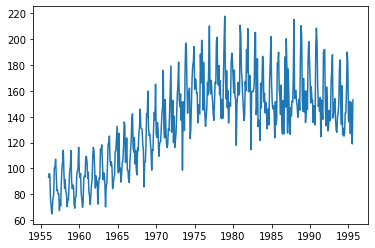

Debido a la gran cantidad de datos existentes y a la peculariedad que tiene dicha serie temporal, se ha decidido aplicar dos metodologías distintas para el análisis:

1.   Obtención de un modelo ARIMA con la totalidad de los datos.
2.   Obtención de un modelo ARIMA únicamente con los datos posteriores al 1975 inclusive.

# Instalación y carga de las librerías necesarias

In [1]:
!pip install pmdarima
!pip install arch

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima
import os
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch.unitroot import PhillipsPerron as PP
from arch.unitroot import DFGLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Lectura del DataSet

In [3]:
os.chdir(r"/Users/raulartiguesfemenia/Desktop/Análisis estadístico de datos/Práctica Series Temporales/Ejercicios")
df= pd.read_csv("DatosEjercicio.csv")

# 1ª metodología: Con la totalidad de los datos.

## Observación del dataframe y las columnas.

In [4]:
df.head(5)

,Month,Value
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


Mediante la tabla anterior se oberva que existen dos variables: <i>Month</i> que habrá que convertirla a fecha y <i>Value</i> la cual es la objetivo.

## Pasamos la Month a formato fecha

In [5]:
df["Month"] = pd.to_datetime(df["Month"], format="%Y-%m-%d %H:%M:%S")
df.index = df["Month"]
del (df["Month"])

En el código anterior se realizó el cambio de tipo de variable <i>Month</i> a formato fecha y se ubicó en el índice del dataframe.

## Primer ploteo de la serie temporal

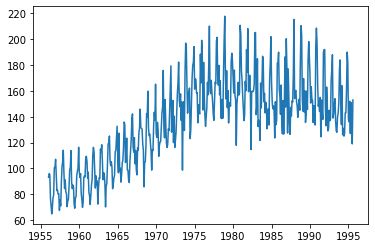

In [6]:
plt.plot(df)

En primer lugar se observa que en la misma gráfica existen dos patrones o tendencias de nuestra variable objetivo. Es a partir, aproximadamente, del 1975 que la serie temporal se mantiene uniforme debido a que su media y varianza se mantienen constantes.

Es por este motivo que el presente análisis se va a dividir en dos estructuras: La primera de ellas tendrá en cuenta todo el dataset y la segunda se realizará una partición empezando en el año 1975 inclusive.

Haciendo interpretaciones para la primera metodología se observa gráficamente que esta serie temporal no es estacionaria debido a que tanto la media como la varianza son crecientes. Esto nos indica que habrá que aplicar diferenciación o cualquier otro método.

## Análisis gráfico y analítico de la estacionariedad

In [7]:
pmdarima.arima.ndiffs(df)

1

El resultado anterior nos sugiere que habría que aplicar una diferenciación en el dataset de grado 1 para poder controlar las métricas mencionadas anteriormente

In [8]:
pmdarima.arima.nsdiffs(df, m = 12)

0

Si le indicamos a la función m=12 para ver si existen un ciclo de estacionalidad anual nos indica que no. Por lo tanto, se procede a aplicar diferenciación de grado 1 para intentar controlar que la media se vuelta más constante.

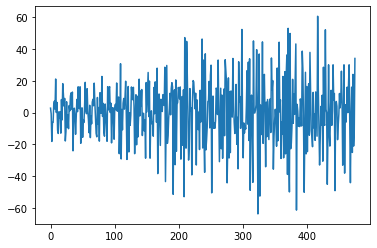

In [9]:
dfdiff = pmdarima.utils.diff(df,lag = 1, differences= 1)
plt.plot(dfdiff)

Observando el gráfico anterior se puede indicar que se ha conseguido una media constante entorno al 0 aplicando una diferenciación de grado 1. Eso sí, la varianza aún no es constante, es por eso que se procede a controlarla a continuación.

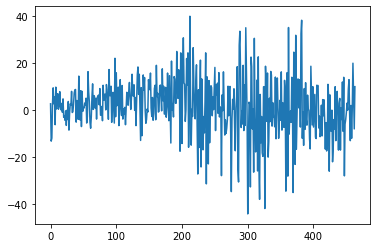

In [10]:
dfdiff_Est = pmdarima.utils.diff(df,lag = 12, differences= 1)
plt.plot(dfdiff_Est)

Diciendo que existe una estacionalidad el problema de la varianza se consigue disminuirla muy poco. Además, se ven 3 ciclos distitnos al resto (picos). El siguiente método que se va a proceder a realizar el averiguar si hay que diferenciar o no respecto al dato anterior y teniendo en cuenta la estacionalidad.

In [11]:
pmdarima.arima.ndiffs(dfdiff_Est)

1

In [12]:
pmdarima.arima.nsdiffs(dfdiff_Est, m = 12)

0

El código anterior sugiere realizar una diferenciación respecto al dato anterior teniendo en cuenta la diferenciación realizada anteriormente, pero no detecta estacionalidad.

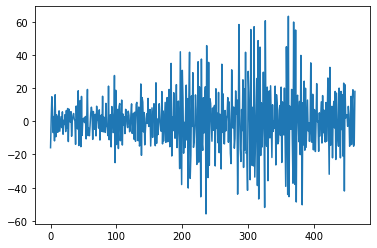

In [13]:
dfdiff_Est2 = pmdarima.utils.diff(dfdiff_Est,lag = 1, differences= 1)

# Graficamos
plt.plot(dfdiff_Est2)

Haciendo la prueba de diferenciar respecto al dataset diferenciado no se consigue grandes resultados. 

Para solucionar el pico de los 3 ciclos existentes, se procede a aplicar logaritmos para así cambiar las unidades de la variables tarjet y hacer los valores más pequeños. Cabe matizar que este tratamiento se va a realizar en el dataset original.


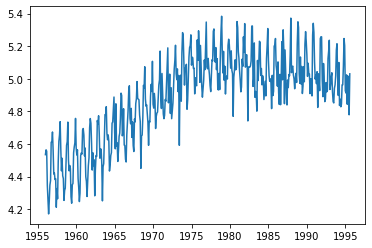

In [14]:
df["Value"] = df["Value"].astype(float)
Log_df= pd.DataFrame(np.log(df["Value"]))

# Graficamos.
plt.plot(Log_df)

En un primer momento de ver la gráfica uno se asusta, pero no debería ser así. Si se pone especial atención en el gráfico se observa que la media no es constante, por lo que se procederá a comprobar si hay que aplicar diferenciación, pero la varianza si parace ser constante. ¡Grandes noticias!

In [15]:
pmdarima.arima.ndiffs(Log_df)


1

La librería nos sugiere realizar una diferenciación de grado 1.

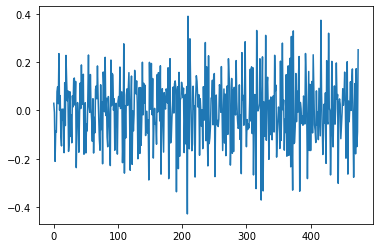

In [16]:
Log_df_Dif = pd.DataFrame(pmdarima.utils.diff(Log_df,lag = 1, differences= 1))
plt.plot(Log_df_Dif)

Esto ya tiene mucha mejor pinta. ¡Gran trabajo!

A continuación, se procede a descomponer la serie y a plotearla para ver las métricas correspondientes.

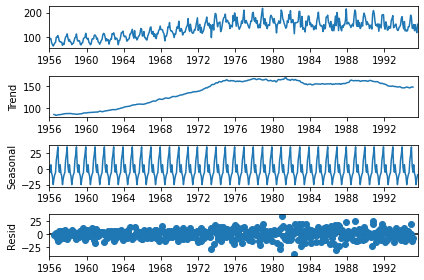

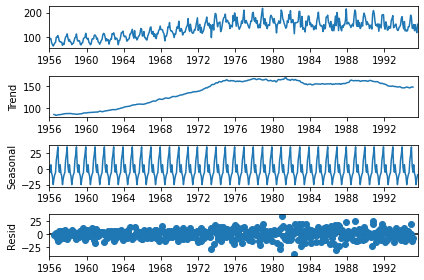

In [17]:
SerieDescompuesta = seasonal_decompose(df, model='additive')

# La graficamos.
SerieDescompuesta.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)

Teniendo en cuenta la totalidad de la serie temporal se observa que si existe una estacionalidad y tendencia. Y es a partir del año 1975 que la tendencia se vuela más constante (indicación de separar el dataset)

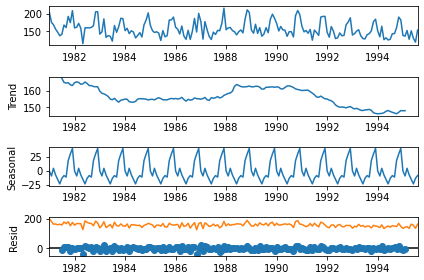

In [18]:
# Vemos la diferencia con los ultimos datos.
df2= df.iloc[300:476,]
SerieDescompuesta2 = seasonal_decompose(df2, model='additive')
SerieDescompuesta2.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)

# Calculamos la Serie sin la componente estacional
SerieNoEstacional = df["Value"] - SerieDescompuesta.seasonal

# La graficamos.
plt.plot(SerieNoEstacional)

Hasta ahora se ha intentado analizar de <b>forma gráfica</b> si existe estacionariedad en la serie temporal. A continuación se va a proceder al análisis técnico, aplicando contrastes de hipotesis de distintos métodos.

Se aplican los contraste de ADF, KPSS, PP y ERS para la serie temporal sin hacerle ningún tipo de transformación a la variable Value.

<b> ADF </b>

H0: Serie NO estacionaria con un &alpha; de 0.1

In [19]:
ADF = adfuller(df["Value"])
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: -2.282661
p-value: 0.177621


No existe suficiente evidencia estadística para poder rechazar H0, por lo que la serie es <b>no estacionaria</b>.

<b> KPSS </b>

H0: Serie estacionaria con un &alpha; de 0.1

In [20]:
KPSS = kpss(df["Value"])
print('KPSS Statistic: %f' % KPSS[0])
print('p-value: %f' % KPSS[1])

KPSS Statistic: 2.965464
p-value: 0.010000


/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Existe suficiente evidencia estadística para poder rechazar H0, por lo que la serie es <b>no estacionaria</b>.

<b> PP </b>

H0: Serie NO estacionaria con un &alpha; de 0.1

In [21]:
PP = PP(df["Value"])
PP

Test Statistic,-7.491
P-value,0.000
Lags,18


Existe suficiente evidencia estadística para poder rechazar H0, por lo que la serie es <b> débilmente estacionaria</b>.

<b> ERS </b>

H0: Serie NO estacionaria con un &alpha; de 0.1

In [22]:
ERS = DFGLS(df["Value"])
ERS

Test Statistic,0.486
P-value,0.834
Lags,17


No existe suficiente evidencia estadística para poder rechazar H0, por lo que la serie es <b>no estacionaria</b>.

Visto que con el conjunto de datos original todos los contrates de hipotesis indican que la serie es <b>no estacionaria</b> se procede a realizar estas mismas técnicas pero con el dataset logaritmico y con diferencia de grado 1 ya que a simple vista y gráficamente se aprecia que tiene un mejor comportamiento.

<b> ADF </b>

H0: Serie NO estacionaria con un &alpha; de 0.1

In [23]:
ADF = adfuller(Log_df_Dif[0])
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: -4.869646
p-value: 0.000040


Existe suficiente evidencia estadística para poder rechazar H0, por lo que la serie es <b>estacionaria</b>.

<b> KPSS </b>

H0: Serie estacionaria con un &alpha; de 0.1

In [24]:
KPSS = kpss(Log_df_Dif[0])
print('KPSS Statistic: %f' % KPSS[0])
print('p-value: %f' % KPSS[1])

KPSS Statistic: 0.009148
p-value: 0.100000


/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


No existe suficiente evidencia estadística para poder rechazar H0, por lo que la serie es <b>estacionaria</b>.

<b> ERS </b>

H0: Serie NO estacionaria con un &alpha; de 0.1

In [25]:
ERS = DFGLS(Log_df_Dif)
ERS

Test Statistic,-0.450
P-value,0.521
Lags,18


No existe suficiente evidencia estadística para poder rechazar H0, por lo que la serie es <b>no estacionaria</b>.

En conclusión, aplicando logaritmo al dataset original y diferenciando los datos en un grado 1 se consigue obtener una serie temporal estacionaria y, por tanto, apta para la aplicación de modelos ARIMA.

## Fase de modelización

En primer lugar se procede a analizar la correlación y correlación parcial del dataset elegido (logaritmo + Diferenciación de grado 1).

/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


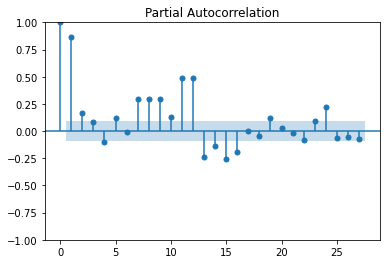

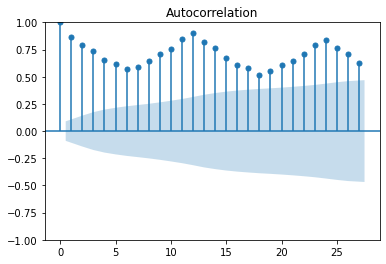

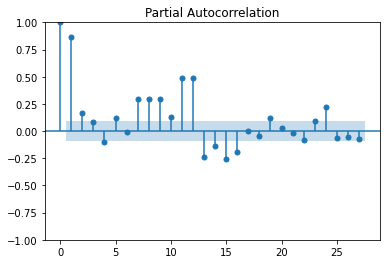

In [38]:
plot_acf(Log_df)
plot_pacf(Log_df)

Como se ha visto anteriormente, el ACF indica gráficamente que habría que aplicar una diferencia. Por tanto, a la hora de crear el modelo hay que indicar una diff=1. 

Por una parte, el modelo PACF indica que se tratará de un modelo AR(2) ya que si existe un truncamiento. Por el otro lado, se observa que habrá que hacer una diferenciación.

<b>Creamos el conjunto train y test para la creación del modelo.</b>

In [89]:
rows=len(Log_df.axes[0])

#El 70% de los datos iran al conjunto train y los restantes al test
cont= round(0.7*rows)

var_train= Log_df.iloc[cont]
train= Log_df.loc[:"1983-10-01 00:00:00"]

var_test= Log_df.iloc[cont+1]
test = Log_df["1983-11-01 00:00:00":]

In [66]:
model = sm.tsa.statespace.SARIMAX(train.iloc[:,0], order=(2,1,1), seasonal_order=(1,0,1,12))

/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [67]:
ArimaModel = model.fit()
print (ArimaModel.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.86534D-01    |proj g|=  2.53211D+00

At iterate    5    f= -9.01712D-01    |proj g|=  2.86719D+00

At iterate   10    f= -9.58179D-01    |proj g|=  5.97623D-01

At iterate   15    f= -9.76371D-01    |proj g|=  2.58618D-01


 This problem is unconstrained.



At iterate   20    f= -1.03105D+00    |proj g|=  6.13239D-01

At iterate   25    f= -1.18725D+00    |proj g|=  4.56188D-01

At iterate   30    f= -1.20996D+00    |proj g|=  1.04199D-01

At iterate   35    f= -1.21015D+00    |proj g|=  1.25331D-02

At iterate   40    f= -1.21059D+00    |proj g|=  4.73960D-02

At iterate   45    f= -1.21209D+00    |proj g|=  4.06562D-02

At iterate   50    f= -1.21215D+00    |proj g|=  1.09641D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     0     0   1.096D-03  -1.212D+00
  F =  -1.2121475503463564     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


El resumen del modelo anterior contiene el gráfico "Tipo de covarianza", que muestra el impacto de cada una de las variables en el pronóstico. Tenemos cuatro variables principales de AR y MA atrasadas. El primer conjunto de variables AR y MA se retrasa en 1 paso de tiempo (ar.L1 y ma.L1, respectivamente), y el segundo conjunto se retrasa en 12 pasos de tiempo (ar.S.L12 yma.S.L12).

Mirando el término "P>abs(z)" en el gráfico, todas las variables se leen como 0. Esto es genial, ya que queremos que nuestros valores P estén lo más cerca posible de 0. Usando un límite de <0,05 para la significación estadística, todos nuestros términos de AR y MA atrasados afectan significativamente el pronóstico del modelo.

Resultado de BIC=-774.866

In [68]:
test["Predicciones"] = ArimaModel.forecast(len(test))

/var/folders/bb/9rcbbv8x2kjb9lvr1vjr1djh0000gn/T/ipykernel_7242/2170066692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicciones"] = ArimaModel.forecast(len(test))


In [69]:
test["Value"]  = np.exp(test["Value"])
test["Predicciones"]  = np.exp(test["Predicciones"])

/var/folders/bb/9rcbbv8x2kjb9lvr1vjr1djh0000gn/T/ipykernel_7242/763842968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Value"]  = np.exp(test["Value"])
/var/folders/bb/9rcbbv8x2kjb9lvr1vjr1djh0000gn/T/ipykernel_7242/763842968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicciones"]  = np.exp(test["Predicciones"])


In [70]:
error_mse = mean_squared_error(
                y_true = test["Value"],
                y_pred = test["Predicciones"]
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 169.07286505366517


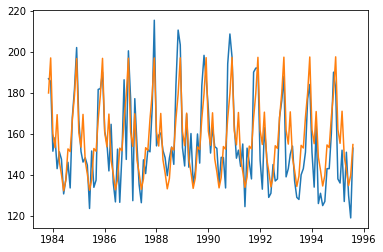

In [45]:
plt.plot(test)

El modelo elegido proporciona unos resultados de test bastante adecuadas ya que se ajustan bastante a la realidad. Para realizar una correcta conclusión se van a plotear y interpretar los valores de los residuos que deben ser ruido blanco.

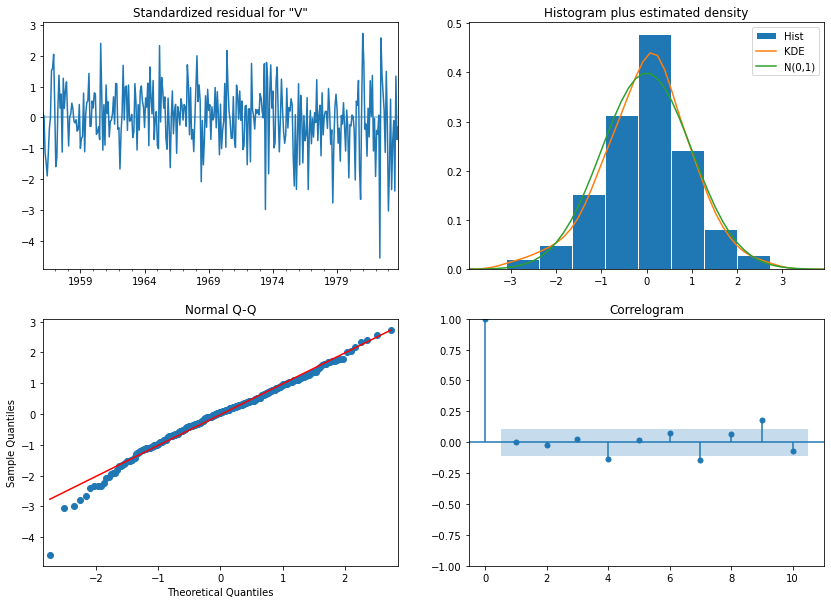

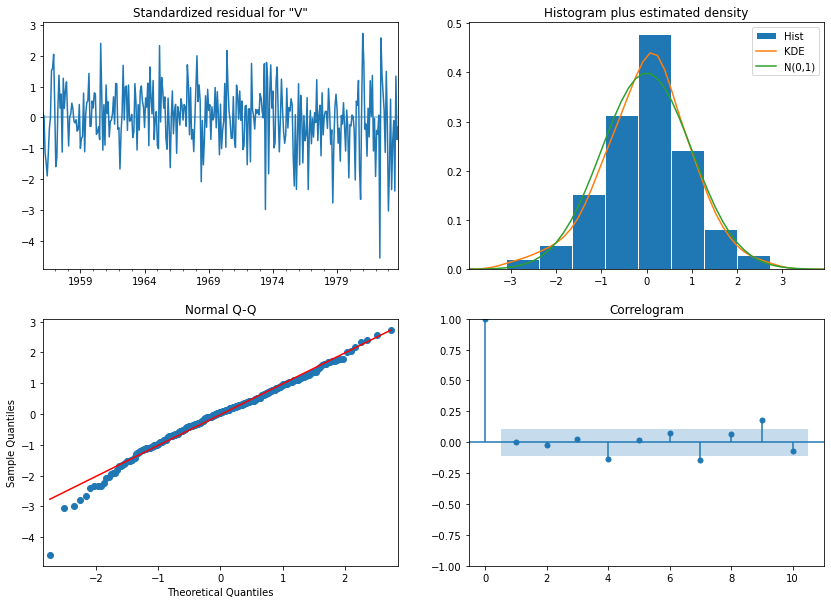

In [114]:
ArimaModel.plot_diagnostics(figsize = (14,10))

/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


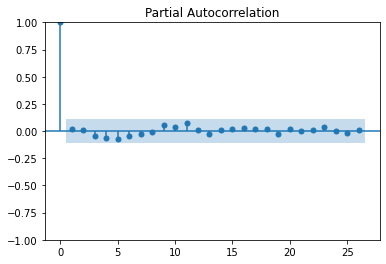

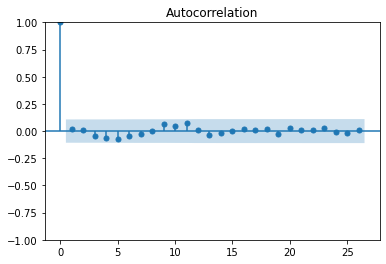

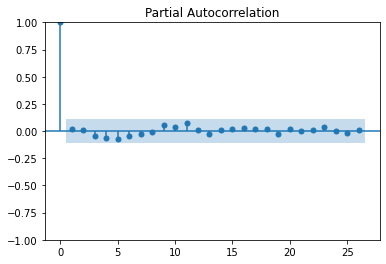

In [115]:
plot_acf(ArimaModel.resid)
plot_pacf(ArimaModel.resid)

Viendo los distintos gráficos que se han ploteado se puede afirmar que los residuos son ruido blanco ya que no siguen ningún patron y estan entorno a la media=0. Por lo tanto, este modelo creado sería válido.

<b> Modelo: ARMA(2,1) con diferenciación de grado 1</b>

Cabe destacar que la mejor forma de encontrar el mejor modelo ARIMA es ir provando con distinos modelos y parámetros. En la vida real se aplica el modelo que se cree mediante la visualización de los gráficos ACF y PACF y posterioremnte se aplica el auto arima.

<b>Implementación del auto arima</b>

Para la correcta ejecución del código y para que funcione adecuado, es necesaria dividir de nuevo el dataset en train (70%) y el test (30%).

In [100]:
rows=len(Log_df.axes[0])

#El 70% de los datos iran al conjunto train y los restantes al test
cont= round(0.7*rows)

var_train= Log_df.iloc[cont]
train= Log_df.loc[:"1983-10-01 00:00:00"]

var_test= Log_df.iloc[cont+1]
test = Log_df["1983-11-01 00:00:00":]

In [101]:
ArimaModel = pmdarima.auto_arima(train, error_action='ignore', seasonal=True, m=12)

In [102]:
ArimaModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  334
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood                 404.943
Date:                            Sun, 19 Feb 2023   AIC                           -789.886
Time:                                    10:21:44   BIC                           -751.805
Sample:                                01-01-1956   HQIC                          -774.701
                                     - 10-01-1983                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.175e-05      0.000      0.216      0.829      -0.000       0.000
ar.L1         -0.9849      0.056    -17.512      0.000      -1.095      -0.875
ar.L2         -0.0672      0.055     -1.219      0.223      -0.175       0.041
ma.L1          0.0645      0.034      1.899      0.058      -0.002       0.131
ma.L2         -0.8918      0.037    -24.358      0.000      -0.964      -0.820
ar.S.L12       0.2094      0.217      0.963      0.335      -0.217       0.635
ar.S.L24       0.7748      0.213      3.631      0.000       0.357       1.193
ma.S.L12       0.0938      0.214      0.438      0.662      -0.326       0.514
ma.S.L24      -0.6556      0.136     -4.809      0.000      -0.923      -0.388
sigma2         0.0047      0.000     14.936      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   2.19   Jarque-Bera (JB):                59.81
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Viendo la significación de los coeficientes del modelo auto arima, se puede decir que los parámetros más sginificativos son un AR(1) y un MA(2). Pero si los combinamos, la solución óptima es un modelo ARMA(2,2) con diferenciación de grado 1 y estacionalidad de grado 12 (anual).

Resultado BIC=-751.805

In [103]:
test["Predicciones"] = Predicciones = ArimaModel.predict(len(test))


# Estas predicciones son logaritmos por lo que hay que invertir el proceso
test["Value"]  = np.exp(test["Value"])
test["Predicciones"]  = np.exp(test["Predicciones"])

/var/folders/bb/9rcbbv8x2kjb9lvr1vjr1djh0000gn/T/ipykernel_7242/3985417349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicciones"] = Predicciones = ArimaModel.predict(len(test))
/var/folders/bb/9rcbbv8x2kjb9lvr1vjr1djh0000gn/T/ipykernel_7242/3985417349.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Value"]  = np.exp(test["Value"])
/var/folders/bb/9rcbbv8x2kjb9lvr1vjr1djh0000gn/T/ipykernel_7242/3985417349.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [106]:
error_mse = mean_squared_error(
                y_true = test["Value"],
                y_pred = test["Predicciones"]
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 169.0898021658117


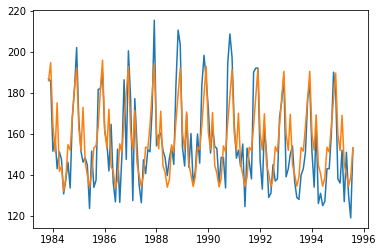

In [105]:
plt.plot(test)

La predicción resulta muy peculiar. Ya que siempre nos está prediciendo los mismos valores para todos los años. Para comprobar la validez del modelo se procede a analizar los residuos del modelo auto arima.

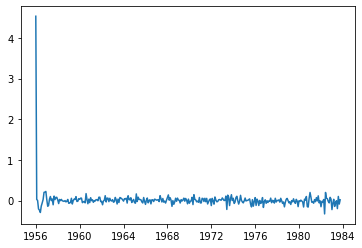

In [95]:
plt.plot(ArimaModel.resid())

/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


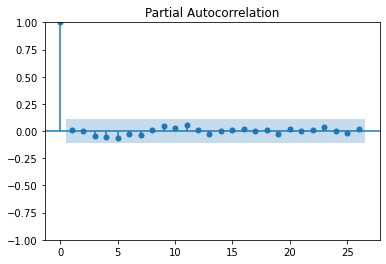

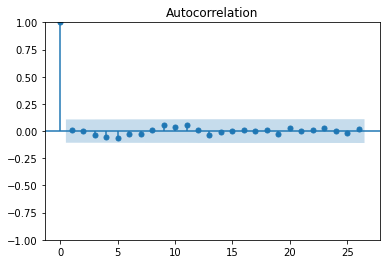

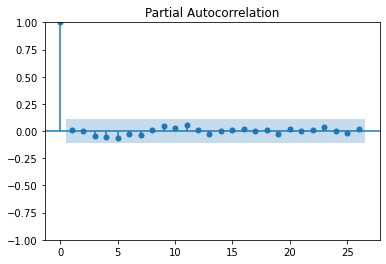

In [125]:
plot_acf(ArimaModel.resid())
plot_pacf(ArimaModel.resid())

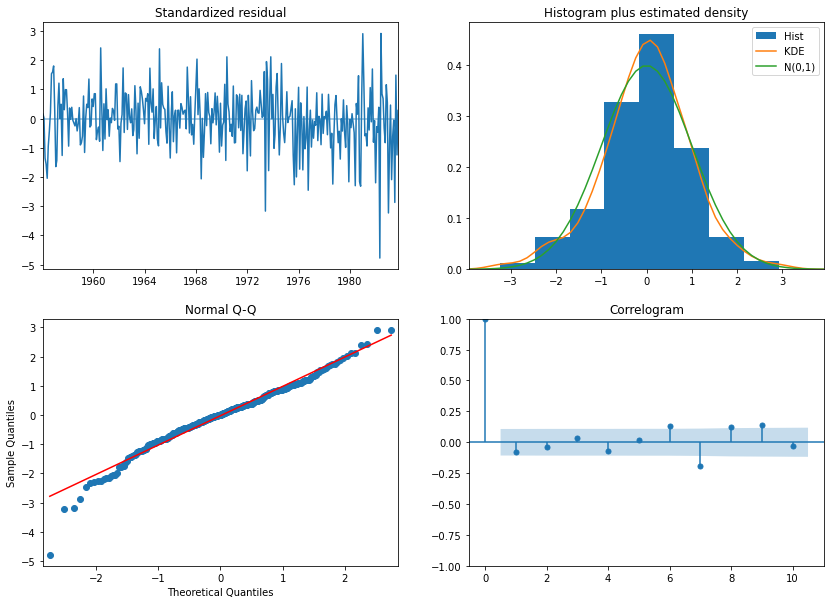

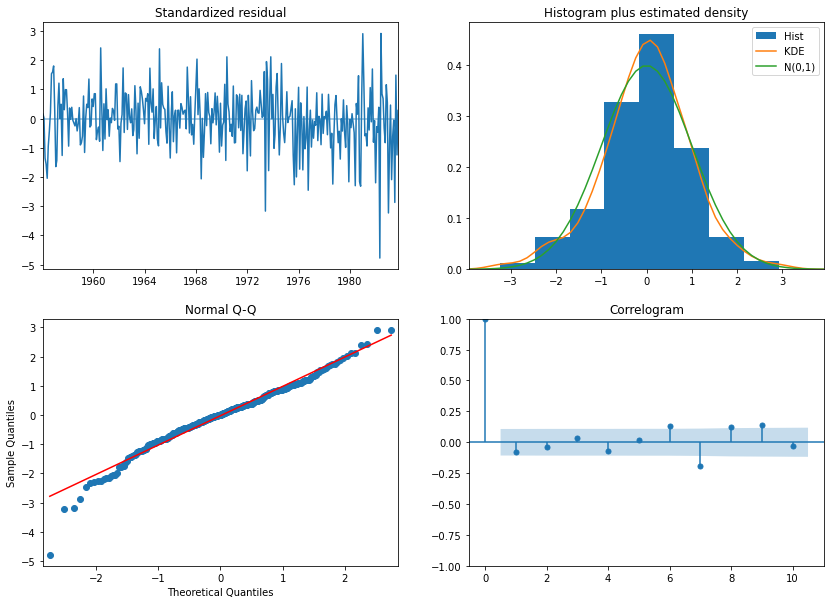

In [126]:
ArimaModel.plot_diagnostics(figsize = (14,10))

Los resultados de los valores de los residuos son bastantes buenos, ya que siguen una distribución normal, una aleatoriedad y su media está entorno a 0 por lo que se considera ruido blanco.

<b> Modelo: ARMA(2,2) con diferenciación de grado 1.

<b> Conclusión:</b> En la primera metodología se ha procedido a realizar un análisis completo de la serie temporal obteniendo visualmente un ARMA(2,1) con diferenciación de grado 1, estacionalidad anual y aplicando logaritmos para conseguir que fuese estacionaria.

Por otra parte, se ha utilizado el auto arima y indica que el mejor modelo es el ARMA(2,2) con diferenciación de grado 1 y estacionalidad anual, aplicando logaritmos para conseguir una serie estacionaria.

Cabe matizar que en los dos modelos vistos los residuos siguen una distribución normal, una aleatoriedad y su media está entorno a 0 por lo que son ruido blanco. Por tanto, ambos modelos son aptos.

En cuanto a la significación de los parametros de los modelos indican, que en AR(2) y MA(1) son significativos ya que tienen un P-valor inferior a &alpha;=0.05. 

Por tanto, no existen grandes diferencias en los dos modelos planteados y esto se puede corraborar con el valor de BIC que en el caso del ARMA(2,1) es de -774.866 y en el modelo ARMA(2,2) es de -751.805 y los errores MSE son 169.0728 y 169.0898, respectivamente.

# 2ª metodología: Partición del dataset.

A continuación se va a proceder a realizar la partición del dataset a partir del año 1975, para ver si es más factible en cuanto a solución final del modelo y al tratamiento del mismo.

In [118]:
df2= df.loc["1975-01-01 00:00:00":]
df2.head(5)

,Value
Month,
1975-01-01,161.4
1975-02-01,169.4
1975-03-01,168.8
1975-04-01,158.1
1975-05-01,158.5


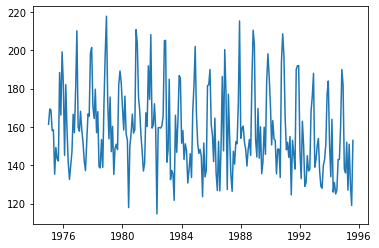

In [119]:
plt.plot(df2)

A simple vista, buenas noticas. La media de la serie temporal parace ser constante entorno a 160. El primer requisito para sea estacionaria se cumple. El segundo requisito parace que tambien se cumple (varianza constante). Para ser más precisos con las decisiones, se va proceder a realizar análisis estadístico para indicar si la serie estacional divida es estacionaria.

<b> ADF </b>

H0: Serie NO estacionaria con un &alpha; de 0.1

In [120]:
ADF = adfuller(df2["Value"])
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: -0.753552
p-value: 0.832387


No existe suficiente evidencia estadística para poder rechazar H0, por lo que la serie es <b>no estacionaria</b>.

<b> KPSS </b>

H0: Serie estacionaria con un &alpha; de 0.1

In [121]:
KPSS = kpss(df2["Value"])
print('KPSS Statistic: %f' % KPSS[0])
print('p-value: %f' % KPSS[1])

KPSS Statistic: 0.571298
p-value: 0.025609


Existe suficiente evidencia estadística para poder rechazar H0, por lo que la serie es <b>no estacionaria</b>.

<b> ERS </b>

H0: Serie NO estacionaria con un &alpha; de 0.1

In [123]:
ERS = DFGLS(df2["Value"])
ERS

Test Statistic,-0.390
P-value,0.545
Lags,15


No existe suficiente evidencia estadística para poder rechazar H0, por lo que la serie es <b>no estacionaria</b>.

In [125]:
pmdarima.arima.ndiffs(df2)

1

/var/folders/bb/9rcbbv8x2kjb9lvr1vjr1djh0000gn/T/ipykernel_7242/164387612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Value"] = df2["Value"].astype(float)


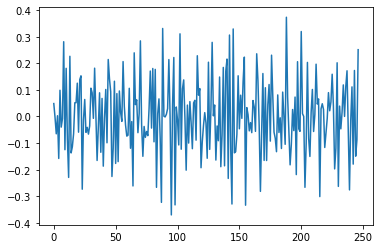

In [127]:
df2["Value"] = df2["Value"].astype(float)
Log_df2= pd.DataFrame(np.log(df2["Value"]))

# Graficamos.
Log_df2_Dif = pd.DataFrame(pmdarima.utils.diff(Log_df2,lag = 1, differences= 1))
plt.plot(Log_df2_Dif)

Visto que con el conjunto de datos original todos los contrates de hipotesis indican que la serie es <b>no estacionaria</b> se procede a realizar estas mismas técnicas pero con el dataset logaritmico y con diferencia de grado 1 ya que a simple vista y gráficamente se aprecia que tiene un mejor comportamiento.

<b> ADF </b>

H0: Serie NO estacionaria con un &alpha; de 0.1

In [128]:
ADF = adfuller(Log_df2_Dif[0])
print('ADF Statistic: %f' % ADF[0])
print('p-value: %f' % ADF[1])

ADF Statistic: -6.973217
p-value: 0.000000


Existe suficiente evidencia estadística para poder rechazar H0, por lo que la serie es <b>estacionaria</b>.

<b> KPSS </b>

H0: Serie estacionaria con un &alpha; de 0.1

In [129]:
KPSS = kpss(Log_df2_Dif[0])
print('KPSS Statistic: %f' % KPSS[0])
print('p-value: %f' % KPSS[1])

KPSS Statistic: 0.010138
p-value: 0.100000


/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


No existe suficiente evidencia estadística para poder rechazar H0, por lo que la serie es <b>estacionaria</b>.

<b> ERS </b>

H0: Serie NO estacionaria con un &alpha; de 0.1

In [130]:
ERS = DFGLS(Log_df2_Dif)
ERS

Test Statistic,-0.403
P-value,0.540
Lags,14


No existe suficiente evidencia estadística para poder rechazar H0, por lo que la serie es <b>no estacionaria</b>.

En conclusión, aplicando logaritmo al dataset original y diferenciando los datos en un grado 1 se consigue obtener una serie temporal estacionaria y, por tanto, apta para la aplicación de modelos ARIMA.

## Fase de Modelización

En primer lugar se procede a analizar la correlación y correlación parcial del dataset elegido (logaritmo + Diferenciación de grado 1).

/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


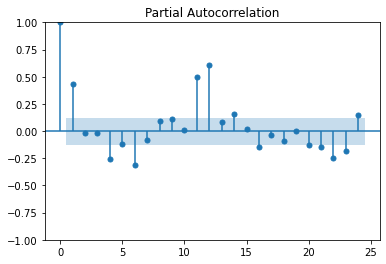

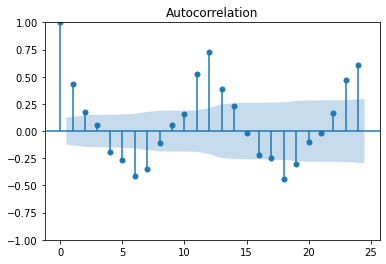

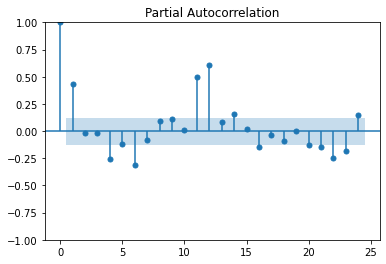

In [131]:
plot_acf(Log_df2)
plot_pacf(Log_df2)

Como se ha visto anteriormente, el ACF indica gráficamente que habría que aplicar una diferencia. Por tanto, a la hora de crear el modelo hay que indicar un diff=1. 

Por una parte, el modelo PACF indica que se tratará de un modelo AR(2) ya que si existe un truncamiento. Por el otro lado, se observa que habrá que hacer una diferenciación.

En este apartado se va realizar el mismo procedimiento que en la metodología 1, para así poder comparar los resultados tanto del auto arima como del modelo creado "manualmente".

Por tanto, se creará un modelo ARMA(2,2) y otro modelo que sugiera el auto arima. Cabe matizar, que va se va a utilziar el dataset aplicando logaritmos.

La forma correcta de resolver el problema es ir probando combinaciones del modelo hasta encontrar la óptima, eso si, sin complicar mucho el modelo.

<b>Creamos el conjunto train y test para la creación del modelo.</b>

In [149]:
rows=len(Log_df2.axes[0])

#El 70% de los datos iran al conjunto train y los restantes al test
cont= round(0.7*rows)

var_train= Log_df2.iloc[cont]
train= Log_df2.loc[:"1989-07-01 00:00:00"]

var_test= Log_df2.iloc[cont+1]
test = Log_df2["1989-08-01 00:00:00":]

In [150]:
model = sm.tsa.statespace.SARIMAX(train.iloc[:,0], order=(2,1,2), seasonal_order=(1,0,1,12))

/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [151]:
ArimaModel = model.fit()
print (ArimaModel.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.99103D-01    |proj g|=  5.15165D-01

At iterate    5    f= -8.07540D-01    |proj g|=  7.47386D-01

At iterate   10    f= -8.92561D-01    |proj g|=  1.41921D-01

At iterate   15    f= -1.01432D+00    |proj g|=  1.34323D-01

At iterate   20    f= -1.03002D+00    |proj g|=  1.01402D-01

At iterate   25    f= -1.03070D+00    |proj g|=  2.34880D-03

At iterate   30    f= -1.03289D+00    |proj g|=  7.65442D-02

At iterate   35    f= -1.03471D+00    |proj g|=  5.10491D-03

At iterate   40    f= -1.03506D+00    |proj g|=  1.13355D-01

At iterate   45    f= -1.04086D+00    |proj g|=  1.08286D-01
  ys=-1.356E-02  -gs= 5.243E-03 BFGS update SKIPPED

At iterate   50    f= -1.04507D+00    |proj g|=  2.88865D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Resultado BIC= -329.660

In [152]:
test["Predicciones"] = ArimaModel.forecast(len(test))
test["Value"]  = np.exp(test["Value"])
test["Predicciones"]  = np.exp(test["Predicciones"])

/var/folders/bb/9rcbbv8x2kjb9lvr1vjr1djh0000gn/T/ipykernel_7242/4060760921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicciones"] = ArimaModel.forecast(len(test))
/var/folders/bb/9rcbbv8x2kjb9lvr1vjr1djh0000gn/T/ipykernel_7242/4060760921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Value"]  = np.exp(test["Value"])
/var/folders/bb/9rcbbv8x2kjb9lvr1vjr1djh0000gn/T/ipykernel_7242/4060760921.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [154]:
error_mse = mean_squared_error(
                y_true = test["Value"],
                y_pred = test["Predicciones"]
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 154.13565228322315


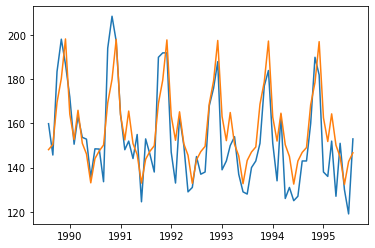

In [155]:
plt.plot(test)

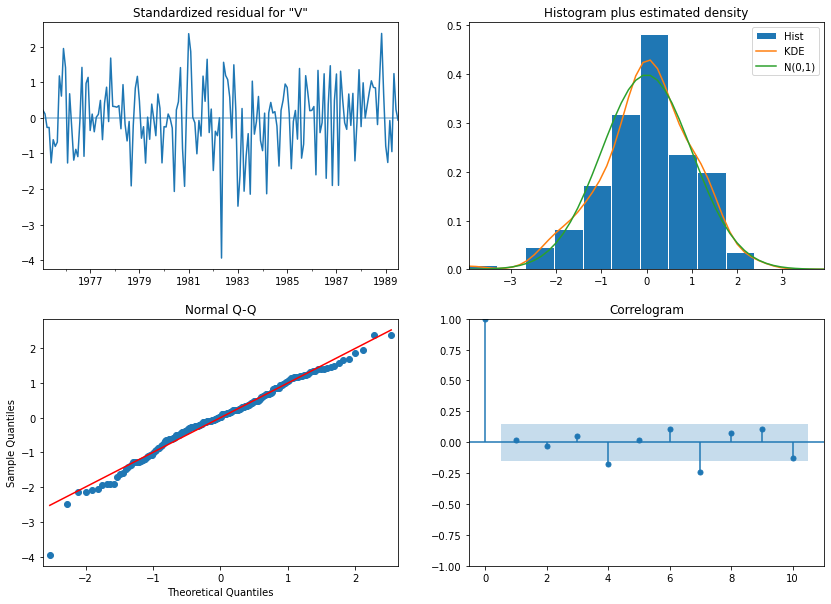

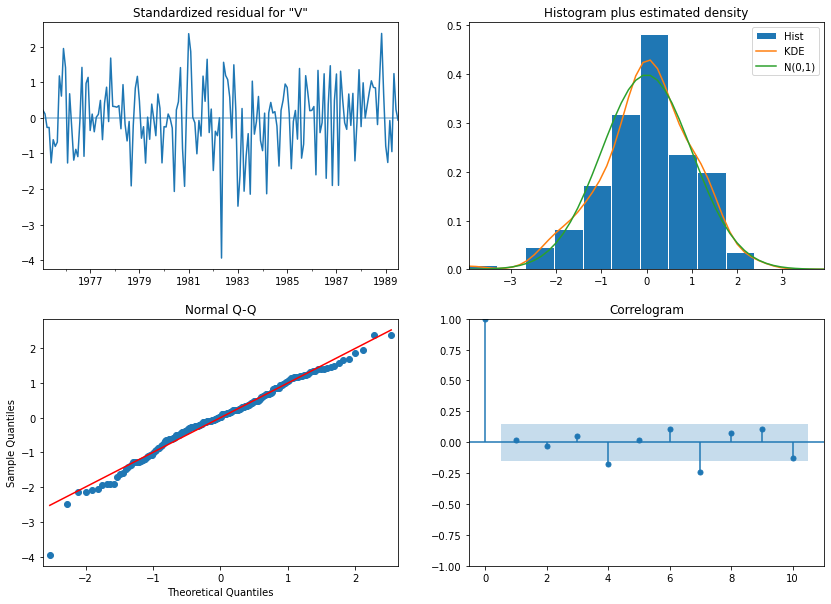

In [141]:
ArimaModel.plot_diagnostics(figsize = (14,10))

El modelo ARMA(2,2) es el mejor hasta el momento, ya que ha imprimido un BIC y un MSE infeiror al resto. De momento seria el método que se elegiria.

Por otra lado, los residuos del modelo si cumplen los estandares ya que siguen una distribución normal, su media está entorno a 0 (ruido blanco) y su dispersión es aleatoria.

Para ver el modelo óptimo para la serie temporal dividida, se aplica la función auto arima.

In [142]:
rows=len(Log_df2.axes[0])

#El 70% de los datos iran al conjunto train y los restantes al test
cont= round(0.7*rows)

var_train= Log_df2.iloc[cont]
train= Log_df2.loc[:"1989-07-01 00:00:00"]

var_test= Log_df2.iloc[cont+1]
test = Log_df2["1989-08-01 00:00:00":]

In [143]:
ArimaModel = pmdarima.auto_arima(train, error_action='ignore', seasonal=True, m=12)

/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


In [144]:
ArimaModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  175
Model:             SARIMAX(0, 0, 1)x(0, 0, [1, 2], 12)   Log Likelihood                 153.696
Date:                                 Sun, 19 Feb 2023   AIC                           -297.391
Time:                                         12:22:10   BIC                           -281.568
Sample:                                     01-01-1975   HQIC                          -290.973
                                          - 07-01-1989                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.0689      0.015    328.172      0.000       5.039       5.099
ma.L1          0.1202      0.071      1.702      0.089      -0.018       0.259
ma.S.L12       0.5651      0.084      6.693      0.000       0.400       0.731
ma.S.L24       0.3208      0.089      3.606      0.000       0.146       0.495
sigma2         0.0098      0.001      9.190      0.000       0.008       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.02
Prob(Q):                              1.00   Prob(JB):                         0.99
Heteroskedasticity (H):               1.31   Skew:                             0.01
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Los resultados de aplicar el auto arima son sorprententes. Este nos indica que el modelo óptima seria un MA(1) sin diferenciación y estacionalidad anual, obteniendo un BIC=-281.568 (el más inferior hasta el momento).

In [145]:
test["Predicciones"] = Predicciones = ArimaModel.predict(len(test))

# Estas predicciones son logaritmos por lo que hay que invertir el proceso
test["Value"]  = np.exp(test["Value"])
test["Predicciones"]  = np.exp(test["Predicciones"])

/var/folders/bb/9rcbbv8x2kjb9lvr1vjr1djh0000gn/T/ipykernel_7242/4005270577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicciones"] = Predicciones = ArimaModel.predict(len(test))
/var/folders/bb/9rcbbv8x2kjb9lvr1vjr1djh0000gn/T/ipykernel_7242/4005270577.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Value"]  = np.exp(test["Value"])
/var/folders/bb/9rcbbv8x2kjb9lvr1vjr1djh0000gn/T/ipykernel_7242/4005270577.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [146]:
error_mse = mean_squared_error(
                y_true = test["Value"],
                y_pred = test["Predicciones"]
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 419.29044429158137


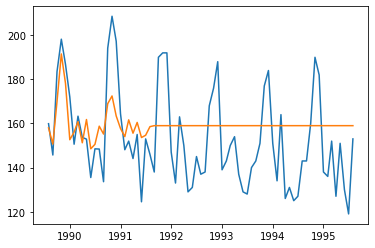

In [147]:
plt.plot(test)

¡MAL! Como era de esperar si se utiliza un MA, a lo largo del tiempo se convierte en la media de la serie temporal, en cuanto a sus predicciones se refiere. Por tanto, el auto arima no nos sirve. Es por eso que no se va a presentar ni los residuos del modelo.

Modelo: ARMA(2,2) con diferenciación de grado 1 y estacionalidad anual

<b> Conclusión:</b> En la segunda metodología se ha procedido a realizar un análisis dividido de la serie temporal obtiendo, visualmente, un ARMA(2,2) con diferenciación de grado 1, estacionalidad anual y aplicando logaritmos para conseguir que fuese estacionaria.

Por otra parte, se ha utilizado el auto arima y nos ha indicado que el mejor modelo es el MA(1) sin diferenciación y estacionalidad anual, aplicando logaritmos para conseguir una serie estacionaria.

Cabe matizar que en los dos modelos vistos los residuos siguen una distribución normal, una aleatoriedad y su media está entorno a 0 por lo que son ruido blanco. Por tanto, ambos modelos son aptos en cuanto a los residuos se refiere.

Por tanto, existen grandes diferencias en los dos modelos planteados y esto se puede corraborar con el valor de BIC que en el caso del ARMA(2,2) es de -329.660 y en el modelo MA(1) es de -281.568 y los errores MSE que son 154.1356 y 419.2904, respectivamente.

# CONCLUSIONES FINALES

A continuación se presente una tabla con los modelos ARIMA comprobados y sus respectivas métricas.

<table style="margin-left:auto;margin-right:auto;">

   <tr>
       <td>
         <h5><b>Metodología</b></h5>
      </td>
      <td>
         <h5><b>Modelo ARIMA</b></h5>
      </td>
      <td>
         <h5><b>¿Logaritmo?</b></h5>
      </td>
      <td>
         <h5><b>¿Diferenciación?</b></h5>
      </td>
      <td>
         <h5><b>¿Estacionalidad?</b></h5>
      </td>
      <td>
         <h5><b>BIC</b></h5>
      </td>
       <td>
         <h5><b>MSE</b></h5>
      </td>
       <td>
         <h5><b>Residuos</b></h5>
      </td>
   </tr>
   <tr>
      <td><font size=3>1º Metodología</td>
      <td><font size=3>ARMA(2,1)</td>
      <td><font size=3>Si</td>
      <td><font size=3>Grado 1</td>
      <td><font size=3>Anual</td>
      <td><font size=3>-774.866</td>
      <td><font size=3>169.0728</td>
      <td><font size=3>Aleatorios, normales, ruido blanco</td>
   </tr>
   <tr>
   <td><font size=3>1º Metodología</td>
      <td><font size=3>ARMA(2,2)</td>
      <td><font size=3>Si</td>
      <td><font size=3>Grado 1</td>
      <td><font size=3>Anual</td>
      <td><font size=3>-751.805</td>
      <td><font size=3>169.0898</td>
      <td><font size=3>Aleatorios, normales, ruido blanco</td>
   </tr>
   <tr>
   <td><font size=3 color="green">2º Metodología</td>
      <td><font size=3 color="green">ARMA(2,2)</td>
      <td><font size=3 color="green">Si</td>
      <td><font size=3 color="green">Grado 1</td>
      <td><font size=3 color="green">Anual</td>
      <td><font size=3 color="green">-329.660</td>
      <td><font size=3 color="green">154.1356</td>
      <td><font size=3 color="green">Aleatorios, normales, ruido blanco</td>
   </tr>
   <tr>
   <td><font size=3>2º Metodología</td>
      <td><font size=3>MA(1)</td>
      <td><font size=3>Si</td>
      <td><font size=3>Grado 1</td>
      <td><font size=3>Anual</td>
      <td><font size=3>-281.568</td>
      <td><font size=3>419.2904</td>
      <td><font size=3>Aleatorios, normales, ruido blanco</td>
   </tr>
</table>

Para concluir el siguente proyecto, se ha ploteado un tabla donde se encuentran las métricas más importantes y decisorias con los 4 modelos ARIMA probados para las 2 metodologías implementadas.

La decisión final, seria utilizar el dataset dividido, es decir, elegir el año 1975 hasta la fecha final para predecir la variable objetivo. Dicho modelo obtiene el error MSE más bajo 154.1356, señalada un verde en la tabla anterior.

<b> MODELO FINAL: 2º metodología mediante un ARMA(2,2) con DIFERENCIACIÓN GRADO 1 y ESTACIONALIDAD ANUAL.</b>